# Not sure what splits / ordering makes sense with this 

# Overview and Introduction 

This set of notebooks provide an overview of the Advanced ACTPol data release 4 (DR4) data products and an introduction to accessing and manipulating these products.  The data products include temperature and polarization maps, lensing maps, and a component maps containing the tSZ signal. 

These data are stored in the CAR (or Plate Carée) format as ndmap objects.  This is distinct from the HealPix format commonly used in cosmology.  Here we provide tools for manipulating these maps and for converting between HealPix and CAR format.   The library that accomplishes this is called [PIXELL](https://github.com/simonsobs/pixell).  

The data products include raw maps at 90, 150, and 220 GHz covering nearly half the sky as well as co-adds of the 90 and 150 GHz channels.   We provide these maps both independently and combined with data from the Planck satellite.   The properties of these maps (resolution, effective white noise level, area etc) are provided in table XXX.  We present examples that show how to examine objects in the maps, stack point sources and XXX. 

We provide both temperature and polarization data.  The polarization angle has been calibrated to XXX degrees (perhaps 0.5.. check), but the polarization leakage of the beam has not been corrected and we do not provide a complete noise model.   We will release fully vetted polarization maps including splits with which the noise can be evaluated in a future release.   In the present form cosmological analysis of these spectra is not possible though one can use these for studies of foregrounds, the galaxy, and (with proper care) point source properties.

DR4 also includes the lensing maps discussed in [Darwish et al. 2020](https://arxiv.org/abs/2004.01139).  The maps are constructed using two frequency bands, 98 GHz and 150 GHz and data from seasons 2014 - 2015 in two regions of the sky, BOSS-North ( \~1633 sq. degrees of sky) and D56 (\~ 456 sq. degrees). 


## Patch and season data splits, component separated maps, Lensing maps and using this Notebook

This notebook will focus on helping users access and understand the different data products included in DR4.  In particular it demonstrates how to access the I, Q, U maps of different regions and from different seasons as well as how to reproduce E and B maps presented in DR4 PAPER.  It can also be used to look at lensing maps discussed in [Darwish et al. 2020](https://arxiv.org/abs/2004.01139) as well as the component separated maps presented in COMPONENT MAP PAPER

The last section of this notebook will give an example as to how to perform harmonic analyses using these CAR maps and Pixell.
 


# Install Healpy and Pixell

This cell will pull the Pixell package from git hup and install healpy so that users can run the note book.

In [0]:
# first install pixell and healpy
# This cell takes some time to run but you'll only need to run it once

!sudo apt-get install automake libtool build-essential
!git clone https://github.com/simonsobs/pixell.git /content/pixell
%cd /content/pixell
!sudo CC=gcc python setup.py build_ext -i
!sudo CC=gcc python setup.py install
%cd /content/

!pip install healpy

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time
import sys
from pixell.pixell import enmap, enplot, reproject, utils
from matplotlib import cm

def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

### Connecting Notebook to the Data files

In order to access the maps and catalog in this folder you'll need to do two things:

1.   Mount your drive so that colab can access your drive
2.    Find the 'Pixell Notebooks' folder that's shared with you, right click it and select 'add shortcut to drive'




In [52]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Pixell notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading in individual maps

The data release includes maps that can be grouded into 20 different sets, one for each patch, season, array and frequency combination.  Each set contains 2 or 4 (2 for patch AA) splits and one map-based co-add which results in a total of 94 data units.  Each of these 94 units also contains 4 FITS files.
 * Source-free maps:  These contain I (or T), Q and U Stokes components and ar in units of $\mu K_{CMB}$ 
 * Source maps:  These contain the point-source signal in units of $\mu K_{CMB} $ .  The simple sum of the source and source-free maps will give a map of the observed sky.
 * ivar (inverse-variance) maps: Roughly proportional to a traditinoal hit count map but includes the variability in detector performances and so is better suited for map-based weighting for map co-addition.
 * Cross-linking maps: T, Q, U components that are used to describe the cross-linking of a dataset.  

Given the volume of available maps we will take a moment to help users access the splits they are interested in.

Maps are named according to the convention:
> act_dr4_season\*\_patch\*\_array\*\_freq\*\_nohwp_night_3pass_set\*\_map_suffix\*

* Season: s13, s14, s15, s16
* patch: D1, D5, D6, D56, D8, BN, AA
* array: PA1, PA2, PA3
* freq: f090, f150
* set: 2way_set0, 2way_set1 or 4way_set(0 - 4)
* map_suffix: map_srcfree.fits, srcs.fits, xlink.fits, ivar.fits

The map suffixes are discussed in more detail in the overview and introduction of this notebook.  

Not all seasons contain all patches or arrays etc. so for a full list of possible cominations reference 2020 DR4 PAPER.

Once the splits of interest have been chosen they can be read in and viewed using Pixell's enmap as shown in the following example.



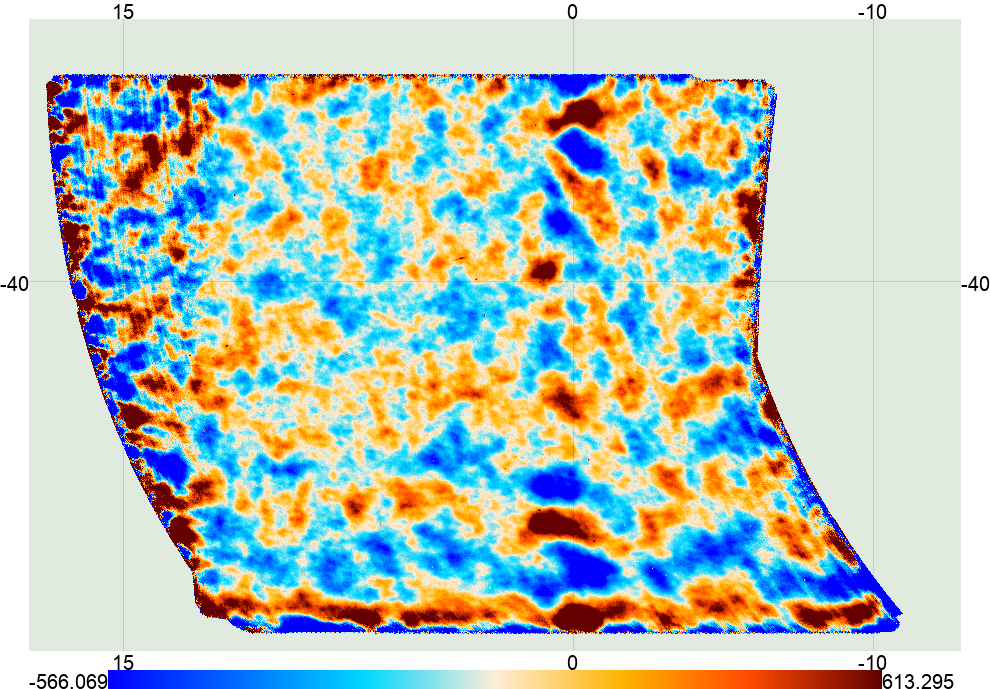

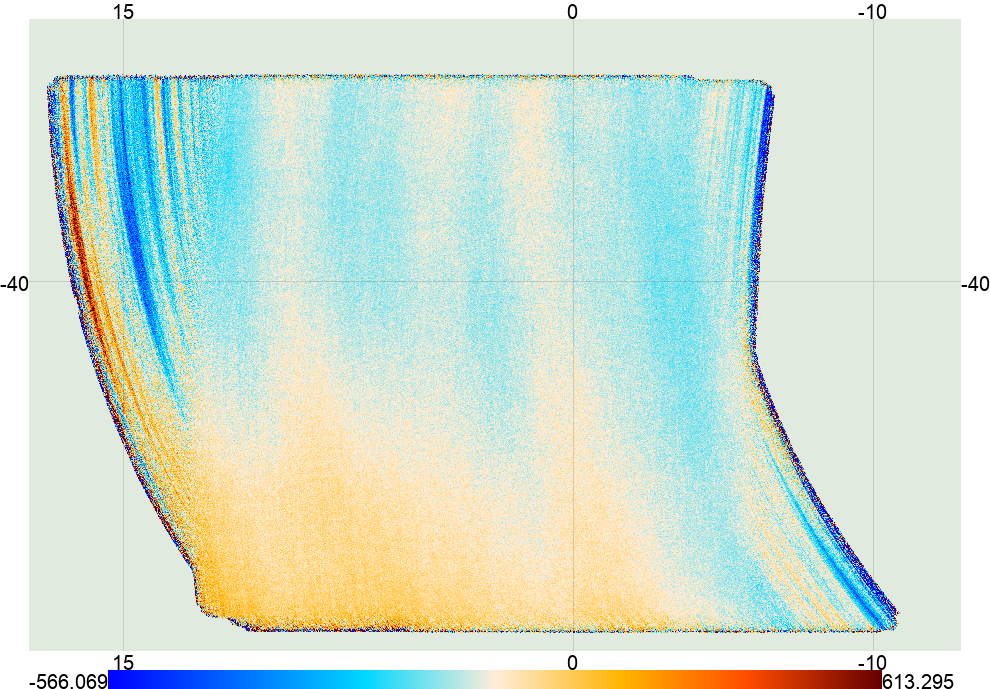

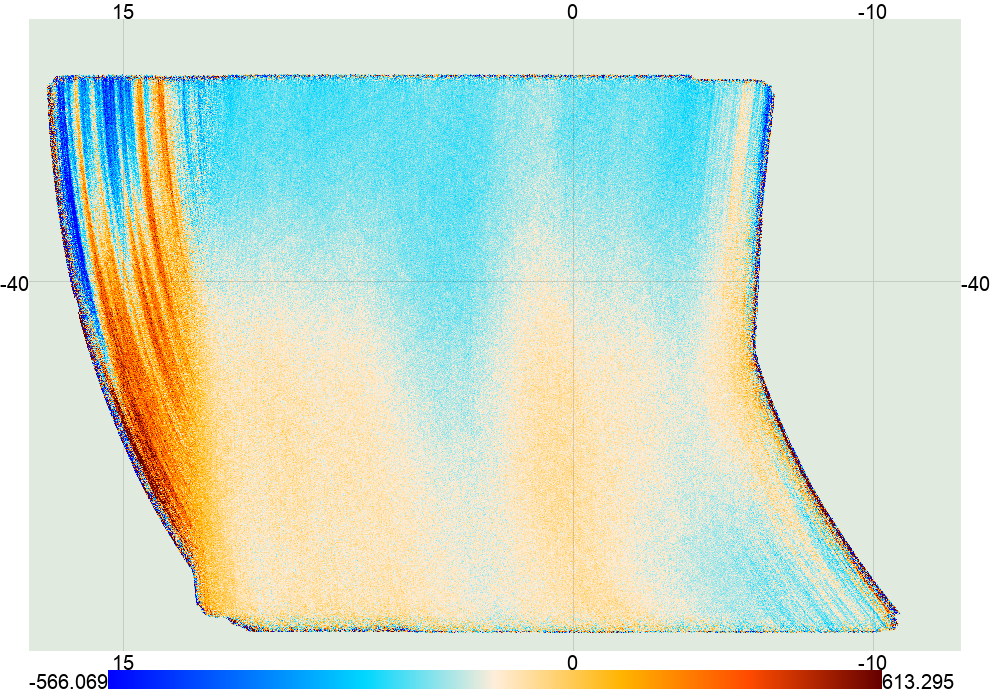

In [53]:
# We will select two maps of the same area, frequency, etc. one of which is source free
# and the other contains just the sources.  
fname_srcfree = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_map_srcfree.fits"
fname_src = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_srcs.fits"

# By combining the two maps chosen above we recover the observed sky with point sources
imap_srcfree = enmap.read_map(path + fname_srcfree)
imap_srcs =   enmap.read_map(path + fname_src)
imap = imap_srcfree + imap_srcs

# We can now plot the maps we just read in
eshow(imap, **{"downgrade": 4, "colorbar": True, "ticks": 25})

Note that in the above map we actually see three maps.  The first is the I (or T) map and the next two are Q and U respectively.  To access just the temperature map, or just the Q or U maps, one can use normal array indexing.  We can also use indexing or enmap's submap feature to view a smaller patch of the map.  

Submaps are referenced by defining a bounding box according to :
> box = [[dec_from, ra_from],[dec_to, ra_to]] $\quad$ (in radians)


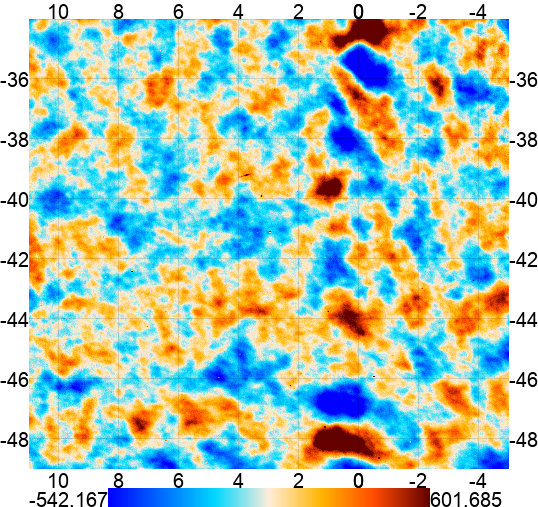

In [54]:
# Define a box to trim the map
box = np.array([[-49,11],[-34,-5]])*utils.degree

# Trim the maps using the submap feature
smap = imap.submap(box)

# Display just the intensity map using numpy array indexing (I = 0, Q = 1, U = 2)
eshow(smap[0], **{"downgrade": 4, "colorbar": True, "ticks": 2})


# Harmonic Analysis using CAR maps

Once the maps are read in and formatted to the correct size they can be used in harmonic alayses.  In order to do so it is necesary to apodize the edges of the maps so that periodic boundary conditions apply.  This can easily be done using the enmap functions and the taper can be adjusted by changing the 'apod_pix' variable which adjusts the number of pixels that are apodized.

Here we choose to display only the I maps, however, the Q and U maps can of course be tapered in the same manner if desired.

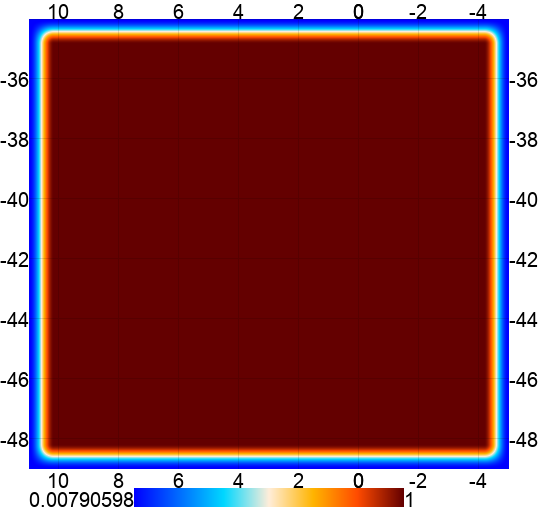

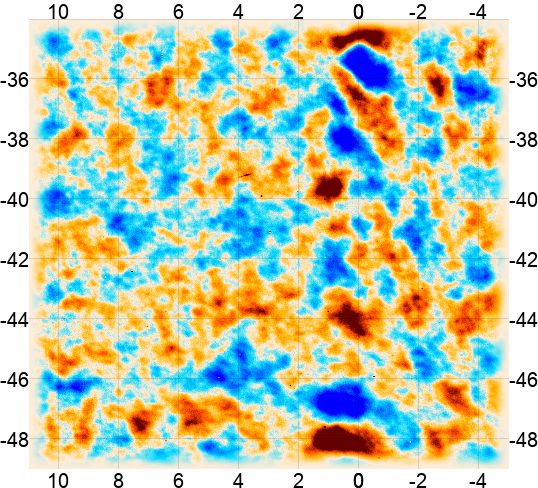

In [55]:
# Define taper using enmap.apod and then plot the taper
apod_pix = 100 
taper = enmap.apod(smap*0+1,apod_pix) 
eshow(taper[0],  **{"downgrade": 4, "colorbar":True, "ticks": 2})

# Apply taper to the smap by multiplying the two maps together
eshow(taper[0]*smap[0], **{"downgrade": 4,  "ticks": 2})

### Fourier transforms using Enmap

Now that we have the maps we can use enmap's functions to fourier transform the map using the 'flat-sky' approximation.  

For ease of use we set the normalization of the fouier trnasformation to physical by passing the 'phys' parameter.  This makes Pixell take into account pixel area factors when calculating the power.

Once you have the fourier transformed map it is possible to make a naive power spectra by multiplying by the conjugate and then binning the spectra.

One thing we note is that Pixell has a function that let's you call the 'modlmap' of a ndmap.  This is a map that gives the distance in fourier space of each pixel to the center of the map.  It's particularly useful for binning the powerspectra and we will use it in the binning function below.

In [0]:
# Fourier transform the map:
kmap = enmap.fft(smap[0]*taper[0], normalize = 'phys')

# Get power
power = (kmap*np.conj(kmap)).real

# Define a function that can bin the power.  
def bin(data,imap, lmax, bin_size):
    modlmap = imap.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0,lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    binned = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return centers, binned

# The Taper we applied earlier effects tge power spectrum. 
# Pixell doesn't have the capability to fully account for the taper
# But we can get an approximate correction by dividing out the following term
w2 = np.mean(taper[0]**2.)

ell, binned_power = bin(power/ w2, smap[0], lmax = 6000, bin_size = 40)

Now that we've binned the power spectrum we made we can plot it quickly to have a look at it.

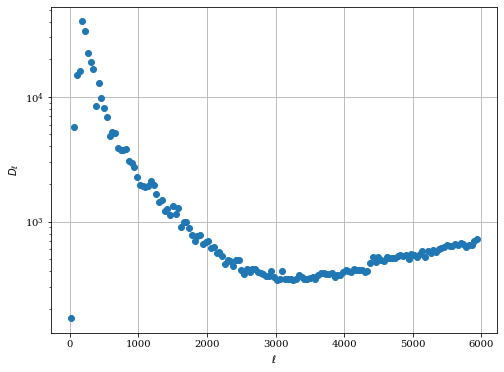

In [57]:
# Now plot the quick powerspectrum we just made

plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.plot(ell,(ell+1)*ell*binned_power/2./np.pi,marker="o",ls="none")
plt.yscale('log')
plt.xlabel('$\\ell$')
plt.ylabel('$D_{\\ell}$')
plt.grid(True)
plt.show()

## Spherical harmonics using Pixell

For this we turn to Pixell's curvedsky functions that enable spherical harmonic analysis of the patches.  The process is very similar what one would do using the HealPix library.  We will get alms from the maps and then from there we get the cls from the alms. 

Again we want to weight our powerspectrum by an area correction factor as well as the taper we've applied

In [0]:
from pixell.pixell import curvedsky 

# First we get the alms
alms = np.cdouble(curvedsky.map2alm(smap[0], lmax = 6000))

# Next step we get the cls using healpy
cls = hp.alm2cl(alms)

# We also want the corresponding ells which we can get easily
ell = np.arange(len(cls))

# Now we calculate the weighting we have to apply to our spectrum due to the 
# trimmed size
w2_new = enmap.area(smap[0].shape, smap[0].wcs)/4. / np.pi

# Now we combine these to get the Dls
Dl = cls*ell**2 / w2_new 

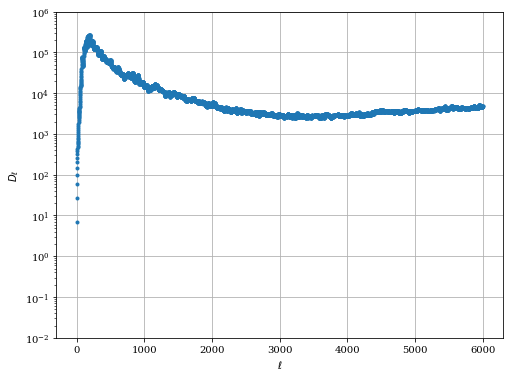

In [59]:
 # Now we can plot our power spectrum

plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.grid(True)
plt.plot(ell, Dl, '.')
plt.yscale('log')
plt.xlabel('$\\ell$')
plt.ylabel('$D_{\\ell}$')
plt.ylim(.01 ,1e6)
plt.show()

### Cross Spectra

A slightly better alternative is to take cross spectra of the small patches.  We will do an example of that here.

In this example we will read in two different sets for the same patch, freqeuncy etc.  We also choose to leave out the point sources.

The basic steps for this are:


1.   Read in the maps of interest
2.   Trim as needed to exclude noisy regions 
3.   Generate alms from the two patches
4.   Cross correlate to get the cls
5.   Adjust cls by accounting for the sky fraction (w2_new) and convert from cls to Dls




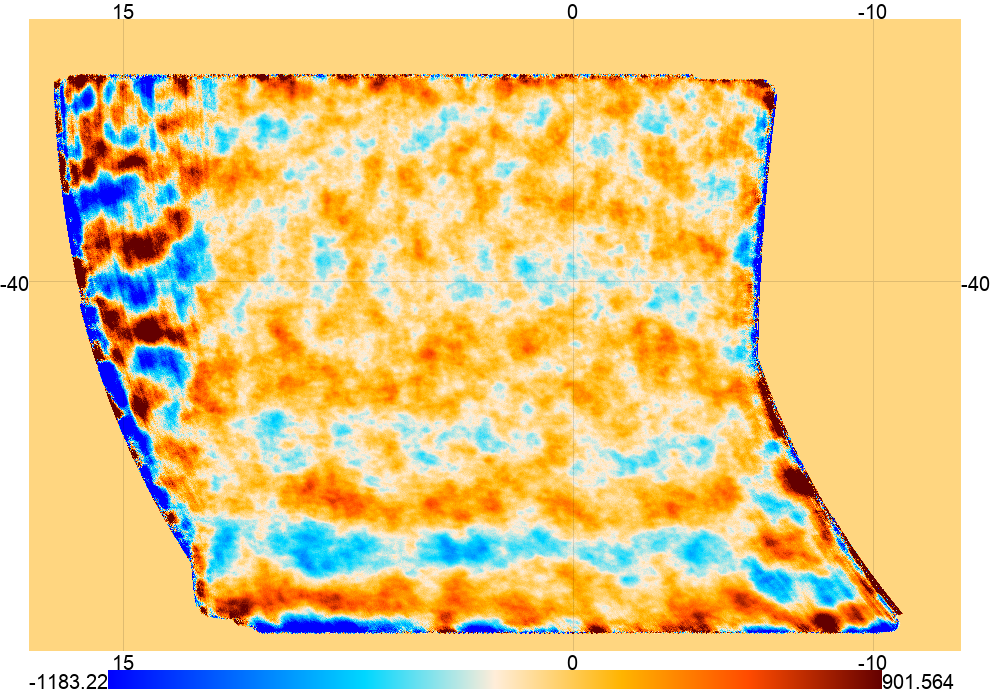

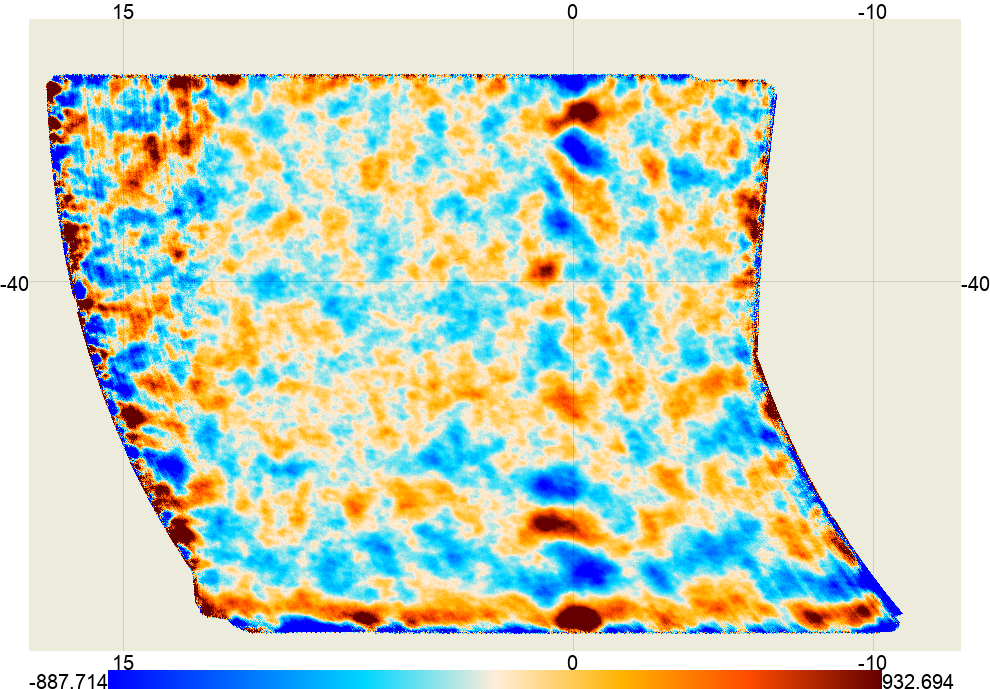

In [60]:
# We will read in another map of this same patch from earlier.  This time let's
# leave the point sources out   
fname_srcfree_1 = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set1_map_srcfree.fits"
fname_srcfree_2 = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_map_srcfree.fits"
fname_srcs = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_srcs.fits"

# By combining the two maps chosen above we recover the observed sky with point sources
imap_srcfree_1 = enmap.read_map(path + fname_srcfree_1) 
imap_srcfree_2 = enmap.read_map(path + fname_srcfree_2) 

# We can now plot the maps we just read in
eshow(imap_srcfree_1[0], **{"downgrade": 4, "colorbar": True, "ticks": 25})
eshow(imap_srcfree_2[0], **{"downgrade": 4, "colorbar": True, "ticks": 25})

We can trim these patches again

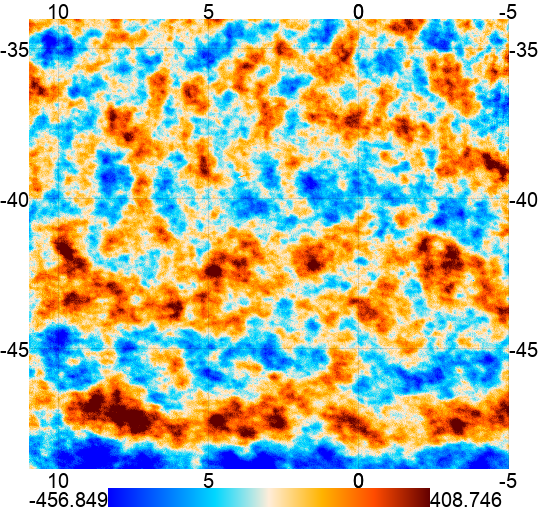

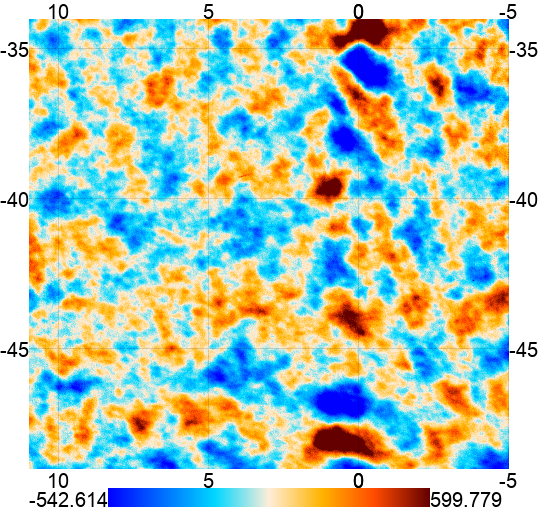

In [61]:
box = np.array([[-49,11],[-34,-5]])*utils.degree
smap_1 = imap_srcfree_1.submap(box)[0]
smap_2 = imap_srcfree_2.submap(box)[0]

eshow(smap_1, **{"downgrade": 4, "colorbar": True, "ticks": 5})
eshow(smap_2, **{"downgrade": 4, "colorbar": True, "ticks": 5})

Now we repeat the spherical harmonic analysis but with a cross spectra

In [0]:
# First we get the alms
alms_1 = np.cdouble(curvedsky.map2alm(smap_1, lmax = 6000))
alms_2 = np.cdouble(curvedsky.map2alm(smap_2, lmax = 6000))

# Next step we get the cls using healpy
cls_2 = hp.alm2cl(alms_1, alms_2)

# We also want the corresponding ells which we can get easily
ell_2 = np.arange(len(cls_2))

# Now we calculate the weighting we have to apply to our spectrum due to the 
# trimmed size
w2_new = enmap.area(smap_1.shape, smap_1.wcs) /4. / np.pi

# Now we combine these to get the Dls
Dl_2 = cls_2*ell_2 **2/ w2_new  

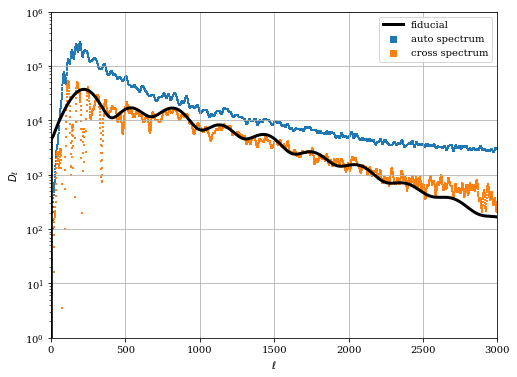

In [63]:
# Read in a camb fiducial spectrum for comparison
from pixell.pixell import powspec
camb_theory = powspec.read_spectrum(path + "camb_theory.dat")
cltt = camb_theory[0,0,:3000]
ls = np.arange(cltt.size)

# Now we can plot our power spectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.grid(True)

# Plot auto, cross and camb
plt.plot(ls,cltt*ls**2.,lw=3,color='k', label = "fiducial")
plt.scatter(ell, Dl,     marker = ',', s = 1 , label = "auto spectrum")
plt.scatter(ell_2, Dl_2, marker = ',', s = 1 , label = "cross spectrum")

lgnd = plt.legend()
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]

plt.yscale('log')
plt.xlabel('$\\ell$')
plt.ylabel('$D_{\\ell}$')
plt.ylim(1 ,1e6)
plt.xlim(0, 3000)
plt.show()

This looks reasonably good now.  We can see the acoustic oscilations in power spectrum and it seems to match our fiducial plot reasonably well.  

While this method works really well for quick powerspectrum tests and for some analyses it's worth noting that their are limitations to it.  We haven't taken into account the fact that the mask we applied by trimming the map has second order effects on the power spectrum and will actually couple modes.  For that reason more in depth power spectrum analysis should use mask deconvolution algroithms such as **namaster**, **pitas** or **pspy**.

# Including information about the Beams

As part of DR4 beam information is readily available and should be used when doing powerspectrum analysis.  Here we demonstrate how to access these beams and generate window functions by squaring and normalizing them.

In [0]:
# Load the data
beam_fname = path + "s15_pa2_f150_nohwp_night_beam_tform_instant_cmbspec.txt"
data = np.loadtxt(beam_fname).T
ell, Bell = data[:2,:12001]

# Convert to window funciton
Well = Bell**2

# Apply normalization
norm = Well[0]
Well /= norm

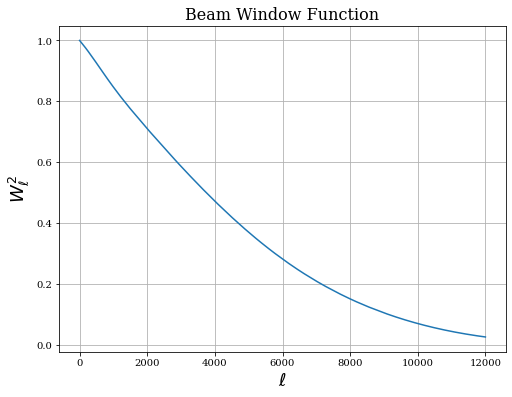

In [65]:
# Now we can plot the normalized beam window function
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ell, Well)

plt.title("Beam Window Function", fontsize = 16)
plt.xlabel('$\\ell$', fontsize = 18)
plt.ylabel('$W_{\\ell}^2$', fontsize = 18)
plt.grid(True)
plt.show()